In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from vit_keras import vit
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from vit_keras import vit
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report


In [14]:
class ChestXRayClassifier:
    def __init__(self, data_directory, csv_file, target_size=(224, 224), batch_size=32):  # Adjust target_size for ViT
        self.data_directory = data_directory
        self.csv_file = csv_file
        self.target_size = target_size
        self.batch_size = batch_size
        self.datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
        self.model = self.build_model()
        self.early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        )

    def build_vit_model(self):
        vit_model = vit.vit_b16(
            image_size=self.target_size,
            activation='softmax',
            pretrained=True,
            include_top=False,
            pretrained_top=False,
            classes=3
        )
        model = Sequential([
            vit_model,
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        return model

    def build_efficientnet_model(self):
        base_model = EfficientNetB0(include_top=False, input_shape=(*self.target_size, 3), weights="imagenet")
        base_model.trainable = False
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])
        return model


    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train_model(self):
        train_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='training',
            target_size=self.target_size
        )
        validation_generator = self.datagen.flow_from_directory(
            self.data_directory,
            batch_size=self.batch_size,
            subset='validation',
            target_size=self.target_size
        )
        history = self.model.fit(
            train_generator,
            epochs=30,
            validation_data=validation_generator,
            callbacks=[self.early_stopping]
        )
        return history
    def plot_history(self, history, model_name):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{model_name} Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def perform_eda(self):
        df_train = pd.read_csv(self.csv_file)
        print(df_train.head())

        # Plot the distribution of classes
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df_train, x='Label')  
        plt.title('Distribution of Classes')
        plt.show()

        # Sample a few images to display
        self.display_sample_images(df_train)

    def display_sample_images(self, df, n=5):
        # Here, we'll show how to apply CLAHE preprocessing to each displayed sample image
        for label in df['Label'].unique():
            fig, axes = plt.subplots(1, n, figsize=(20, 5))
            fig.suptitle(f'Sample images for class: {label}')
            sample_images = df[df['Label'] == label].sample(n=n)
            for ax, (_, row) in zip(axes, sample_images.iterrows()):
                image_path = os.path.join(self.data_directory, label.lower(), row['Image'])
                if not os.path.isfile(image_path):
                    print(f"File not found: {image_path}")
                    continue
                # Apply CLAHE on read images
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                image = clahe.apply(image)
                ax.imshow(image, cmap='gray')
                ax.axis('off')
            plt.show()

    def evaluate_model(self, test_directory, model_name="Model"):
        datagen = ImageDataGenerator()
        test_generator = datagen.flow_from_directory(
            test_directory,
            target_size=self.target_size, 
            batch_size=self.batch_size,
            shuffle=False
        )
        
        predictions = self.model.predict(test_generator)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = test_generator.classes
        cm = confusion_matrix(true_labels, predicted_labels)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=test_generator.class_indices.keys(),
                    yticklabels=test_generator.class_indices.keys())
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        print(f"Classification Report for {model_name}:\n",
            classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))


In [11]:
# Usage example:
data_directory = 'train'  # Update paths as needed
csv_file = 'train.csv'
test_directory = 'test'


In [13]:
classifier = ChestXRayClassifier(data_directory, csv_file)

AttributeError: 'ChestXRayClassifier' object has no attribute 'build_model'

In [6]:
classifier.compile_model()

In [9]:
history = classifier.train_model()

Found 958 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Epoch 1/30
30/30 [==============================] - 960s 31s/step - loss: 1.4963 - accuracy: 0.3633 - val_loss: 1.0909 - val_accuracy: 0.3613
Epoch 2/30
30/30 [==============================] - 953s 32s/step - loss: 1.0906 - accuracy: 0.3747 - val_loss: 1.0854 - val_accuracy: 0.3908
Epoch 3/30
30/30 [==============================] - 826s 27s/step - loss: 1.0880 - accuracy: 0.3956 - val_loss: 1.0812 - val_accuracy: 0.3908
Epoch 4/30
30/30 [==============================] - 868s 29s/step - loss: 1.0906 - accuracy: 0.3800 - val_loss: 1.0818 - val_accuracy: 0.3613
Epoch 5/30
30/30 [==============================] - 1213s 41s/step - loss: 1.0799 - accuracy: 0.4123 - val_loss: 1.0834 - val_accuracy: 0.3908
Epoch 6/30
30/30 [==============================] - 887s 30s/step - loss: 1.0876 - accuracy: 0.3883 - val_loss: 1.0843 - val_accuracy: 0.3908
Epoch 7/30
30/30 [==============================] - 4217s 144s/st

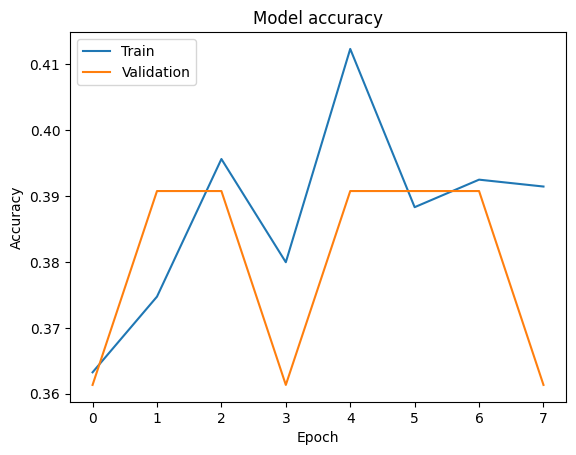

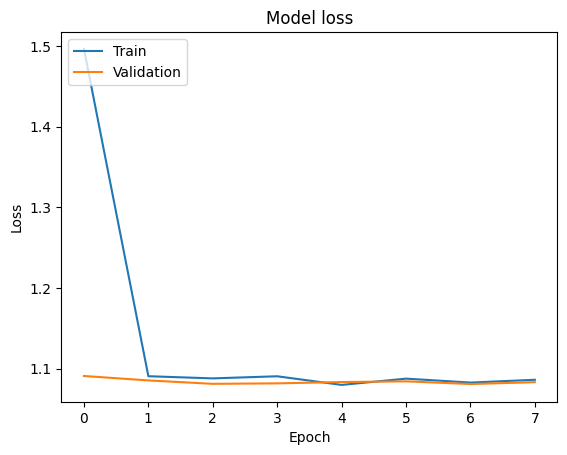

In [10]:
classifier.plot_history(history)

Found 1288 images belonging to 3 classes.


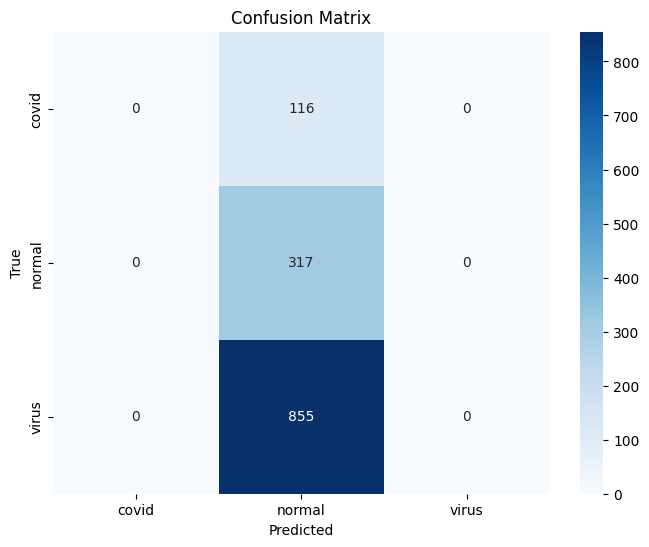

Classification Report:
               precision    recall  f1-score   support

       covid       0.00      0.00      0.00       116
      normal       0.25      1.00      0.40       317
       virus       0.00      0.00      0.00       855

    accuracy                           0.25      1288
   macro avg       0.08      0.33      0.13      1288
weighted avg       0.06      0.25      0.10      1288



/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [11]:
classifier.evaluate_model(test_directory)

In [8]:
# For EfficientNetB0
efficientnet_model = classifier.build_efficientnet_model()  # Assuming a method that builds and returns this model
efficientnet_history = classifier.train_model(efficientnet_model, train_generator, validation_generator)
classifier.plot_history(efficientnet_history, title="EfficientNetB0 Training")

AttributeError: 'ChestXRayClassifier' object has no attribute 'build_efficientnet_model'

In [ ]:
# For Vision Transformer (ViT)
vit_model = classifier.build_vit_model()  # Assuming a method that builds and returns this model
vit_history = classifier.train_model(vit_model, train_generator, validation_generator)
classifier.plot_history(vit_history, title="Vision Transformer Training")
